# 0: Section Overview

In the final section of our report, we will directly compare the performance of each model on a randomly selected country within the test data and visualize each model's predicted reproduction rate across the time period. We will also assess how each model performed on the entire test dataset, using our chosen performance metric, Mean Squared Error (MSE), to evaluate overall predictive performance. Finally, we will discuss the strengths and limitations of MSE as an evaluation metric and its implications for model reliability in similar predictive tasks.


# 1: Necessary Imports



In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor

# 2: Data access

As done previously, we need to access the test and training datasets.

In [3]:
test_filepath = r"C:\Users\markm\OneDrive\Documents\University\Year 4\dst\GitHub\Assessment_1\Train_and_Test_data\test.xlsx" # Enter your file path for the train data
train_filepath = r"C:\Users\markm\OneDrive\Documents\University\Year 4\dst\GitHub\Assessment_1\Train_and_Test_data\train.xlsx" # Enter your file path for the test data

test_data = pd.read_excel(test_filepath)
train_data = pd.read_excel(train_filepath)

# 3: Model Performance Comparison

As previously mentioned, this section of the conclusion will focus on comparing the performance of the models based on our performance metric, Mean Squared Error (MSE). We will evaluate MSE for a randomly selected country within the test dataset as well as for the entire dataset to provide a broader view of each model's accuracy. Additionally, we will perform visualization comparisons, plotting the reproduction rate for the selected country with each model’s predictions overlaid. This way, we can analyze both the quantitative result and how well each models' prediction aligns visually with the actual reproduction rate. Note, each group member has put forward their cross-validated, best model (i.e. the best implimentation of their model and not just the vanilla version).

### Selecting a country 

The following block of code takes all the unique iso_codes from the test data and randomely selects one of them. This iso_code will determine which country from the test data we perform this model comparison on.

In [4]:
random.seed(21) # for replicability
iso_codes = test_data['iso_code'].unique()
random_iso_code = random.choice(iso_codes)
print(random_iso_code)

GBR


Now, we want to train our models in exactly the same way as before but instead of testing the models on the entire testing dataset, we can filter the test results to only include data from our randomely selected country. We also need to perform the standard selecting of covariate columns as we have done in the previous model implimentations

In [11]:
random_country_test_data = test_data[test_data['iso_code'] == random_iso_code]

#### Training data

In [5]:
covariates = ['Mean_Stringency_Index','CH_Index', 'Gov_Resp_Index', 'Econ_Sup_Index','days_since','total_cases','total_deaths','new_cases','new_deaths']
covariates_and_repr = covariates + ['reproduction_rate']
train_data_filtered = train_data[covariates_and_repr]
X_train = train_data_filtered[covariates]
y_train = train_data_filtered['reproduction_rate']
print()
print(X_train.shape)
print(len(y_train))


(134618, 9)
134618


#### Testing data

In [6]:
test_data_filtered = test_data[covariates_and_repr]
X_test = test_data_filtered[covariates]
y_test = test_data_filtered[['reproduction_rate']]
print()
print(X_test.shape)
print(len(y_test))



(32431, 9)
32431


#### Testing data for random country 

We want to access the test data just for the single country aswell.

In [12]:
random_country_X_test = random_country_test_data[covariates]
random_country_Y_test = random_country_test_data['reproduction_rate']

#### Retraining the models with cross-validated hyperparameters

In order to plot the Reproduction rate, we need to train and test each model as in each model section. we will also test each model on solely the GBR data aswell to see how each model performed in this particular country case.

#### Linear Model

In [15]:
linear_model = LinearRegression()
# Fit the model on the training data
linear_model.fit(X_train, y_train)
# Make predictions on the test data
y_pred_linear = linear_model.predict(X_test)
#print("y_pred shape:", y_pred_linear.shape)
# Calculate Mean Squared Error (MSE) on the test data
mse_linear = mean_squared_error(y_test, y_pred_linear)
R_squared_linear = linear_model.score(X_test, y_test)


y_pred_linear_random_country = linear_model.predict(random_country_X_test)
mse_linear_random_country = mean_squared_error(random_country_Y_test, y_pred_linear_random_country)
# R_squared_linear_random_country = linear_model.score(random_country_X_test, random_country_Y_test)

print(mse_linear)

0.13260849618243836


#### KNN model

Lucy performed multiple implimentations of the KNN model. She also created an enemble method with XGboost in an attempt to improve model performance. Furthermore, it is important to note that in the KNN section, Lucy implimented a scaling function on her test and training covariate data which worked to marginally improve her results. Given we want to fairly compare model performance, we will not perform any scaling on our datasets to ensure all test and training data is identical for each model.

##### KNN model

In [16]:
knn = KNeighborsRegressor(n_neighbors=100, p=1, weights='distance') 
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)

y_pred_knn_random_country = knn.predict(random_country_X_test)
mse_knn_random_country = mean_squared_error(random_country_Y_test, y_pred_knn_random_country)

##### Ensemble model

In [17]:
knn = KNeighborsRegressor(n_neighbors=15, p=1, weights='distance')
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05, max_depth=5)
ensemble_model = VotingRegressor(estimators=[('knn', knn), ('xgb', xgb_model)])
ensemble_model.fit(X_train, y_train)
y_pred_em = ensemble_model.predict(X_test)
mse_em = mean_squared_error(y_test, y_pred_em)

y_pred_em_random_country = ensemble_model.predict(random_country_X_test)
mse_em_random_country = mean_squared_error(random_country_Y_test, y_pred_em_random_country)


#### RF model

Similarly, Harry performed multiple implimentations of the RF model. The model initialised below was his final model submission adjusted through cross-validation. Since Harry implimented his section in R, in order to overlay the rf model result onto the graph, we reimplimented the RF model in python. 

In [19]:
rf_model_tuned = RandomForestRegressor(
    n_estimators=350,      # Number of trees
    max_features=2,        # Number of features to consider at each split (equivalent to mtry in R)
    bootstrap=True,        # Sample with replacement
    n_jobs=3,              # Number of parallel jobs to run (-1 to use all processors)
    random_state=42
)

# Fit the model
rf_model_tuned.fit(X_train, y_train)
y_pred_rf = rf_model_tuned.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
R_squared_rf = rf_model_tuned.score(X_test, y_test)
print(mse_rf)

y_pred_rf_random_country = rf_model_tuned.predict(random_country_X_test)
mse_rf_random_country = mean_squared_error(random_country_Y_test, y_pred_rf_random_country)



0.11426398813722571


##### Stacked model

In [20]:
meta_model = LinearRegression()

stacking_model = StackingRegressor(
    estimators=[('knn', knn), ('linear', linear_model), ('rf', rf_model_tuned)],
    final_estimator=meta_model,  # Meta-model
    cv=5                          # Cross-validation folds
)
# Train the stacked model on scaled data
stacking_model.fit(X_train, y_train)
# Predict using the stacked model
y_pred_stacked = stacking_model.predict(X_test)
# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred_stacked)
y_pred_stacked_random_country = rf_model_tuned.predict(random_country_X_test)
mse_stacked_random_country = mean_squared_error(random_country_Y_test, y_pred_stacked_random_country)


## Visualising the reproduction rate w/ model predictions

We are going to plot the actual reproduction rate against all the predictions by our models. This kind of plot illustrates what we might expect in practice if we were to forecast the reproduction rate of the virus for a country without existing data. For instance, if we aimed to map the reproduction rate for a country like North Korea, these model predictions provide a helpful starting point. 

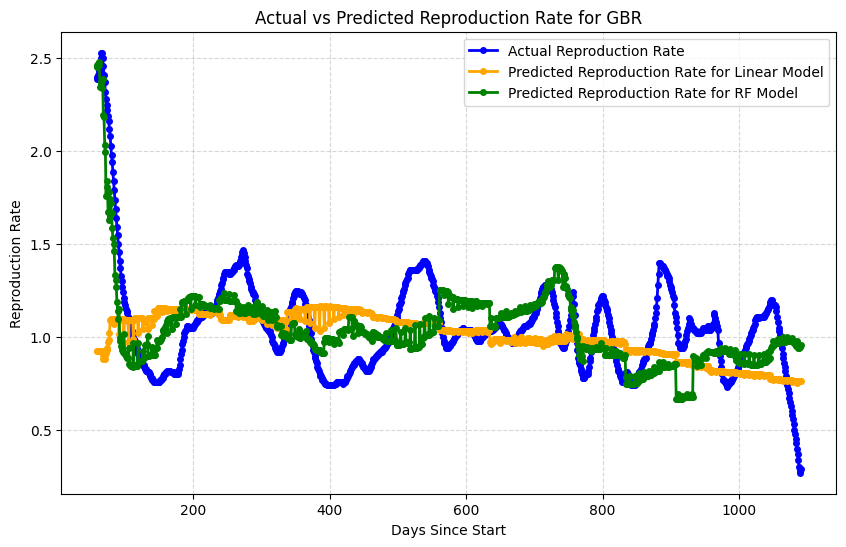

In [21]:
plt.figure(figsize=(10, 6))

# Plot actual and predicted values with different line styles and marker sizes
plt.plot(random_country_test_data['days_since'], random_country_test_data['reproduction_rate'], 
         label="Actual Reproduction Rate", color='blue', marker='o', markersize=4, linewidth=2)
plt.plot(random_country_test_data['days_since'], y_pred_linear_random_country, 
         label="Predicted Reproduction Rate for Linear Model", color='orange', marker='o', markersize=4, linewidth=2)
plt.plot(random_country_test_data['days_since'], y_pred_rf_random_country, 
         label="Predicted Reproduction Rate for RF Model", color='green', marker='o', markersize=4, linewidth=2)

# Add labels and title
plt.title(f"Actual vs Predicted Reproduction Rate for {random_iso_code}")
plt.xlabel("Days Since Start")
plt.ylabel("Reproduction Rate")
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

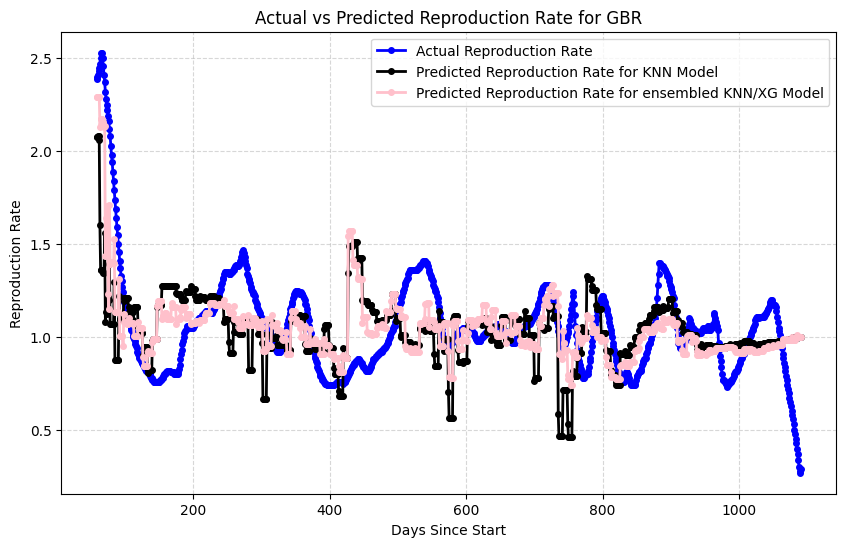

In [22]:
plt.figure(figsize=(10, 6))

# Plot actual and predicted values with different line styles and marker sizes
plt.plot(random_country_test_data['days_since'], random_country_test_data['reproduction_rate'], 
         label="Actual Reproduction Rate", color='blue', marker='o', markersize=4, linewidth=2)
plt.plot(random_country_test_data['days_since'], y_pred_knn_random_country, 
         label="Predicted Reproduction Rate for KNN Model", color='black', marker='o', markersize=4, linewidth=2)
plt.plot(random_country_test_data['days_since'], y_pred_em_random_country, 
         label="Predicted Reproduction Rate for ensembled KNN/XG Model", color='pink', marker='o', markersize=4, linewidth=2)

# Add labels and title
plt.title(f"Actual vs Predicted Reproduction Rate for {random_iso_code}")
plt.xlabel("Days Since Start")
plt.ylabel("Reproduction Rate")
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

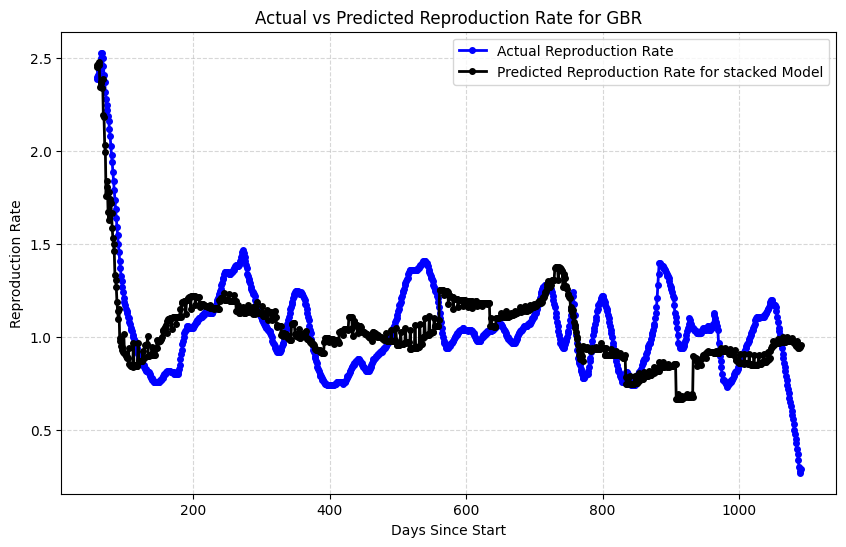

In [23]:
plt.figure(figsize=(10, 6))

# Plot actual and predicted values with different line styles and marker sizes
plt.plot(random_country_test_data['days_since'], random_country_test_data['reproduction_rate'], 
         label="Actual Reproduction Rate", color='blue', marker='o', markersize=4, linewidth=2)
plt.plot(random_country_test_data['days_since'], y_pred_stacked_random_country, 
         label="Predicted Reproduction Rate for stacked Model", color='black', marker='o', markersize=4, linewidth=2)


# Add labels and title
plt.title(f"Actual vs Predicted Reproduction Rate for {random_iso_code}")
plt.xlabel("Days Since Start")
plt.ylabel("Reproduction Rate")
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [24]:
# Print a header
print('QUANTITATIVE RESULTS\n')
print(f'{"Model":<25} {"Metric":<45} {"Value":<10}')
print('-' * 80)

# Linear Model Results
print(f'{"Linear Model":<25} {"MSE using ALL test data":<45} {mse_linear:.4f}')
print(f'{"Linear Model":<25} {"MSE using only GBR test data":<45} {mse_linear_random_country:.4f}')
print()

# Random Forest Model Results
print(f'{"Random Forest Model":<25} {"MSE using ALL test data":<45} {mse_rf:.4f}')
print(f'{"Random Forest Model":<25} {"MSE using only GBR test data":<45} {mse_rf_random_country:.4f}')
print()

# knn Model Results
print(f'{"KNN Model":<25} {"MSE using ALL test data":<45} {mse_knn:.4f}')
print(f'{"KNN Model":<25} {"MSE using only GBR test data":<45} {mse_knn_random_country:.4f}')
print()

print(f'{"ensembled knn/XG Model":<25} {"MSE using ALL test data":<45} {mse_em:.4f}')
print(f'{"ensembled knn/XG Model":<25} {"MSE using only GBR test data":<45} {mse_em_random_country:.4f}')
print()

print(f'{"Stacked Model":<25} {"MSE using ALL test data":<45} {mse:.4f}')
print(f'{"Stacked Model":<25} {"MSE using ALL test data":<45} {mse_stacked_random_country:.4f}')

QUANTITATIVE RESULTS

Model                     Metric                                        Value     
--------------------------------------------------------------------------------
Linear Model              MSE using ALL test data                       0.1326
Linear Model              MSE using only GBR test data                  0.0917

Random Forest Model       MSE using ALL test data                       0.1143
Random Forest Model       MSE using only GBR test data                  0.0473

KNN Model                 MSE using ALL test data                       0.1735
KNN Model                 MSE using only GBR test data                  0.0822

ensembled knn/XG Model    MSE using ALL test data                       0.1362
ensembled knn/XG Model    MSE using only GBR test data                  0.0486

Stacked Model             MSE using ALL test data                       0.1135
Stacked Model             MSE using ALL test data                       0.0473


On a quantative level, the model that demonstrated the highest performance, as indicated by the lowest Mean Squared Error (MSE) value, was the Random Forest model with an MSE of 0.1143. As shown in the results table, the KNN model’s performance was particularly poor with an MSE of 0.1735, yielding a performance even worse than that of the baseline model when considering its performance on the whole dataset. Although ensembling techniques of the KNN model provided some improvement in model performance, this enhancement was not sufficient to surpass the baseline MSE making it the worst performing model in general in our particular testing phase. Additionally, stacking of our initial three models (Linear,KNN,RF) lead to the best result on the test data as a whole, showcasing its capability to enhance predictive accuracy through model combination.

Moreover, what was noticeable in this particular evaluation was that all models performed signficantly better when solelly focusing on the GBR data compared to the entire dataset. For instance, the RF model achieved an mse of 0.4073 when focusing solely on the GBR data whilst the KNN model achieved 0.0822 and the ensembled XG boost/KNN model achieved 0.0486. This substantial improvement in performance metric. This improved performance when testing solely on the GBR data could be attributed to a variety of factors such as the GBR data likely being more consistently recorded and maintained than in other countries within the broader test dataset that may introduce additional variability and noise through unreliable data entry which could confused the models and lead to worse results in terms of performance metric.

It was also notable that the performance improvement from the entire test dataset to the GBR subset varied significantly between models. For instance, the MSE for the Random Forest, KNN, ensemble, and stacked models more than halved when evaluated on GBR data alone, suggesting that these models better adapted to the patterns in GBR’s data. In contrast, the linear model’s MSE showed a smaller decrease, indicating it was less responsive to this dataset shift. As mentioned, complex models can better differentiate between signal and noise, improving their performance when focused on a smaller, more consistent subset like GBR. 

The prediction plots for GBR further support these observations. The linear model’s predictions appear almost more static, leading to large residual errors, particularly at the beginning of the period when the true reproduction rate is high. Meanwhile, the higher-performing models, such as the stacked regressor and Random Forest, visually track the actual reproduction rate trends more closely. Both these models captured the general shape of the curve in places, tracking the rise and fall from day 200 to 400 and approximating the drop around day 800. However, some errors persist, notably between days 800-1000, highlighting potential underfitting where the models might lack the complexity required to capture all the fluctuations in the reproduction rate.

This analysis suggests that while complex ensemble models like Random Forest and the stacked regressor are better suited to the nuances of the GBR subset, there remains room for improvement, especially in capturing the dynamic changes in reproduction rates over time as all the models tended not to fluxuate as much as the true reproductione rate.

# 4: Performance Metric Evaluation


In our models tasked with predicting the COVID-19 reproduction rate, we used MSE as our performance metric. This gave us a straightforward figure that gives the average squared difference between actual and predicted reproduction rates.  

  

This is often preferred as a performance metric for regression tasks, as it is easy to compute and understand, whilst also being a powerful indicator of a model's predictability. In our case, it allowed us to compare the accuracy of a linear regression, KNN and Random Forest models, with Random Forest being the best performer.  

  

Whilst being successful, we also found some limitations which affected its ability to perform: 

  

- Sensitivity to outliers [1]: MSE’s squared component increases the influence of larger errors. In our dataset, sudden changes in reproduction rate were present, this meant MSE would overemphasise these deviations, which can lead to a warped understanding of our model's accuracy.  

  

- Mean Absolute Error (MAE) [2]: Using MAE as an alternative performance metric could’ve been an option also. This calculates the average absolute difference between predicted and actual values. This would solve our problem of being too sensitive to outliers, since we don’t square the error terms, amplifying them. It may also help us assess whether Random Forests' lower MSE came from better handling of outliers, or genuine accuracy.  

  

In summary, while MSE had it’s limitations, it was a successful performance metric for our purpose in this project. It gave us a straightforward, interpretable measure of error across all our models. MSE gave valuable insights into model accuracy and allowed us to compare models consistently. 

# 5: Limitation acknowledgement and Final Takeaway

Ultimately, the best-performing (non-stacked) model in our analysis was the Random Forest Model. This model demonstrated a lower Mean Squared Error (MSE) compared to the other implementations, both when focused on a single country—such as in our real-world scenario of predicting North Korea's reproduction rate—and when evaluated on a larger subset of the entire dataset. The plot of the predicted reproduction rates corroborated these findings, as the RF model mirrored the upward and downward trends of the actual reproduction rate observed in Great Britain (GBR) the best at various time intervals. While the primary objective of this project was to compare the performance of different models in mapping the COVID-19 reproduction rate, rather than solely to identify the best-performing model, it is important to note that none of these models performed exceptionally well. As discussed in the baseline model section under 'Assessing these results,' caution should be exercised when applying these models in real-world situations. 

For our random forest regression model, used to predict COVID-19 reproduction rates, we began with a vanilla model. After some adaptations, we then decided to cross-validate to find which hyperparameters would perform best. Here, it was hard to identify all the optimal hyperparameters due to this process being so computationally expensive. We chose to focus on the number of trees. With more time and computational power, we would have liked to explore ‘min.node.size’, ‘sample.fraction’ and ‘mtry’ in the same way to further improve our model. Additionally, exploring feature selection could have provided further insight into our independent variables' significance. This then could have simplified our model by omitting less useful variables.

Similarly, for our KNN model, computational power was a limiting factor to being able to explore the most optimal hyperparameters. Using k-fold cross validation with a large number of neighbors, and implementing the stacked model with certain hyperparameters required high computational power. Another limitation was that this model had a higher MSE than anticipated. It was only by combining the KNN model with alternative models using ensemble methods, or by dramatically increasing the number of neighbors, that we managed to significantly reduce the MSE. Otherwise, optimising the hyperparameters of the KNN model had some effect on the MSE, but was not significant.

## References


[1] https://encord.com/glossary/mean-square-error-mse/#:~:text=Sensitivity%20to%20Outliers%3A%20MSE%20is,scale%20of%20the%20target%20variable. 

[2] https://medium.com/@nirajan.acharya777/choosing-between-mean-squared-error-mse-and-mean-absolute-error-mae-in-regression-a-deep-dive-c16b4eeee603

# References